# Import Libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.structured import *
from fastai.column_data import *

In [3]:
TRAIN_DATA = 'tmp/taxi-train-v9-Baseline'
TEST_DATA = 'tmp/taxi-test-v9-Baseline'
TEST_CSV = 'data/nyc-taxi/test.csv'
PATH = 'tmp'

# Load data

In [4]:
%%time
train_df = pd.read_feather(TRAIN_DATA)
test_df = pd.read_feather(TEST_DATA)

CPU times: user 520 ms, sys: 957 ms, total: 1.48 s
Wall time: 1.48 s


In [5]:
train_df.shape, test_df.shape, test_key.shape

((53925796, 14), (9914, 13), (9914, 1))

In [ ]:
# train_df = train_df.sample(5_000_000)

In [ ]:
# train_df.shape, test_df.shape, test_key.shape

In [9]:
# y_train = train_df['fare_amount'].values
# X_train = train_df.drop('fare_amount', axis=1)

In [10]:
# X_train.shape, y_train.shape

In [11]:
# trainshape = X_train.shape
# testshape = test_df.shape

In [12]:
# print("Does Train feature equal test feature?: ", all(X_train.columns == test_df.columns))

In [6]:
train_df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'week', 'dayofweek', 'day', 'hour', 'longitude_distance',
       'latitude_distance'],
      dtype='object')

In [7]:
cat_vars = ['passenger_count', 'year', 'month', 'week', 'dayofweek', 'day', 'hour']

contin_vars = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
   'longitude_distance', 'latitude_distance']

dep = 'fare_amount'
n = len(train_df) 
n

53925796

In [8]:
for v in cat_vars: 
    train_df[v] = train_df[v].astype('category').cat.as_ordered()

In [9]:
# for v in cat_vars: test_df[v] = test_df[v].astype('category').cat.as_ordered()
apply_cats(test_df, train_df)

In [10]:
X_train, y_train, nas, mapper = proc_df(train_df, 'fare_amount', do_scale=True)

In [11]:
test_df[dep] = 0

In [12]:
X_test, _, nas, mapper = proc_df(test_df, 'fare_amount', do_scale=True, mapper=mapper, na_dict=nas)

In [13]:
X_train.shape, y_train.shape, X_test.shape

((53925796, 13), (53925796,), (9914, 13))

In [14]:
m = 500_000
val_idx = get_cv_idxs(n, val_pct=m/n)

In [15]:
def rmse(y_pred, targ):
    pct_var = (targ - y_pred)
    return math.sqrt((pct_var**2).mean())

# Deep Learning

In [16]:
md = ColumnarModelData.from_data_frame(".", val_idx, X_train, y_train.astype(np.float32), 
                                       cat_flds=cat_vars, bs=256, test_df=X_test)

In [17]:
cat_vars

['passenger_count', 'year', 'month', 'week', 'dayofweek', 'day', 'hour']

In [18]:
cat_sz = [(c, len(train_df[c].cat.categories)+1) for c in cat_vars]

In [19]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz];emb_szs

[(7, 4), (8, 4), (13, 7), (54, 27), (8, 4), (32, 16), (25, 13)]

In [20]:
max_y = np.max(y_train)
y_range = (0, max_y*1.2)
y_range

(0, 180.0)

In [21]:
TMP_PATH = "/tmp/tmp"
MODEL_PATH = "/tmp/model/"

In [28]:
# m = md.get_learner(emb_szs, len(X_train.columns)-len(cat_vars),
#                    0.04, 1, [1000,500,100], [0.008,0.08, 0.01], 
#                    y_range=y_range, tmp_name=TMP_PATH,
#                    models_name=MODEL_PATH)
# m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 28)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 27]),
                           ('trainable', True),
                           ('nb_params', 1458)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

In [22]:
m = md.get_learner(emb_szs, # size of embeddings
                   len(X_train.columns)-len(cat_vars), # size of continuous vars
                   0.04, # embedding droput
                   1, # number of output
                   [1024,512], # fully connected layer hidden units
                   [0.001,0.01]) # fully connected layers droput

In [30]:
m.lr_find()

 60%|███████████████████████████████████████                          | 11511/19141 [02:40<01:46, 71.58it/s, loss=53.6]

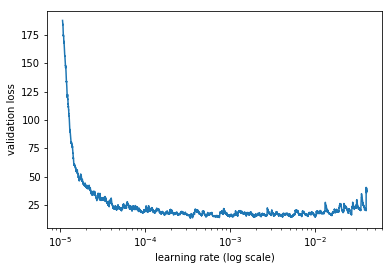

In [31]:
m.sched.plot(100)

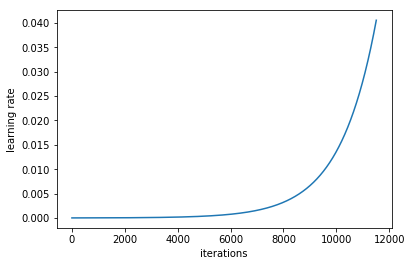

In [32]:
m.sched.plot_lr()

In [23]:
lr = 1e-4

In [24]:
m.fit(lr, 1, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                              
    0      13.795506  12.293915  3.415295  



[array([12.29392]), 3.4152947805715845]

In [25]:
m.fit(lr, 1, cycle_len=1,  metrics=[rmse])

epoch      trn_loss   val_loss   rmse                              
    0      13.221082  11.780013  3.340326  
    1      11.905302  11.586187  3.312758                          



[array([11.58619]), 3.31275750661321]

In [27]:
m.fit(lr, 2, cycle_len=1, cycle_mult=2, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                              
    0      12.349729  11.384561  3.283438  
    1      12.327252  11.379355  3.284585                          
    2      11.789829  11.222596  3.260277                          


[array([11.2226]), 3.2602768418871664]

In [55]:
predictions = m.predict(True)

In [56]:
predictions = predictions.reshape(-1)

In [57]:
test_df_raw = pd.read_csv(TEST_CSV, usecols=['key'])

In [59]:
submission = pd.DataFrame(
    {'key': test_df_raw.key, 'fare_amount': predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('fastai.csv', index = False)

In [60]:
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.566683
1,2015-01-27 13:08:24.0000003,10.981107
2,2011-10-08 11:53:44.0000002,5.081404
3,2012-12-01 21:12:12.0000002,9.426112
4,2012-12-01 21:12:12.0000003,17.252987
